In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models
from typing import List

In [2]:
from torch.utils.data import Dataset, DataLoader
DATA_FOLDER = 'mask_output/images'


# Data loading + splits (train/val/test)

In [3]:
from collections import defaultdict, Counter
from typing import Tuple, Optional, Sequence
import torchvision.transforms as T
from torch.utils.data import Subset, WeightedRandomSampler


In [4]:
from dataset import FilenameLabelImageDataset
import random
class RandomRotate90:
    def __call__(self, x):
        k = random.randint(0, 3) 
        return torch.rot90(x, k, dims=(-2, -1))


In [5]:
def make_transforms(image_size: int = 224, train: bool = True):
    # Minimal baseline; swap/extend for augmentation later.
    ops = [
        T.Resize((image_size, image_size)),
    ]
    if train:
        # Example augmentation hook (keep minimal):
        ops.append(T.RandomHorizontalFlip(p=0.5))
        ops.append(T.RandomVerticalFlip(p=0.5))
    
    ops += [
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    if train:
        ops.append(RandomRotate90())
    return T.Compose(ops)

def stratified_split_indices(labels: Sequence[int], val_frac: float = 0.15, test_frac: float = 0.15) -> Tuple[list[int], list[int], list[int]]:
    by_class = defaultdict(list)
    for i, y in enumerate(labels):
        by_class[int(y)].append(i)

    train_idx  = []
    val_idx = []
    test_idx = []

    for y, idxs in by_class.items():
        idxs = idxs.copy()
        perm = torch.randperm(len(idxs)).tolist()
        idxs = [idxs[i] for i in perm]
        n = len(idxs)
        n_test = int(round(test_frac * n))
        n_val = int(round(val_frac * n))
        if n >= 3:
            n_test = max(1, n_test)
            n_val = max(1, n_val)
        if n_test + n_val >= n:
            n_test = min(n_test, max(0, n - 1))
            n_val = min(n_val, max(0, n - 1 - n_test))
        n_train = n - n_val - n_test
        if n_train <= 0 and n > 0:
            n_train = 1
            if n_val > 0:
                n_val -= 1
            elif n_test > 0:
                n_test -= 1
        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train + n_val])
        test_idx.extend(idxs[n_train + n_val:])

    def _shuffle(xs: list[int]) -> list[int]:
        if not xs:
            return xs
        perm = torch.randperm(len(xs)).tolist()
        return [xs[i] for i in perm]

    return _shuffle(train_idx), _shuffle(val_idx), _shuffle(test_idx)

def make_class_weights(targets: Sequence[int], num_classes: int) -> torch.Tensor:
    counts = torch.bincount(torch.as_tensor(list(targets), dtype=torch.long), minlength=num_classes).clamp_min(1)
    total = counts.sum().float()
    weights = total / (num_classes * counts.float())
    return weights

def make_dataloaders(
    data_folder: str,
    batch_size: int = 32,
    image_size: int = 224,
    val_frac: float = 0.15,
    test_frac: float = 0.15,
    seed: int = 42,
    num_workers: int = 0,
    exclude_classes: Optional[set[str]] = None,
    balance_train: bool = True,
 ):
    train_tf = make_transforms(image_size=image_size, train=True)
    eval_tf = make_transforms(image_size=image_size, train=False)

    base_ds = FilenameLabelImageDataset(data_folder, transform=None, exclude_classes=exclude_classes)
    train_idx, val_idx, test_idx = stratified_split_indices(base_ds.targets, val_frac, test_frac)

    train_ds = base_ds.with_transform(train_tf)
    val_ds = base_ds.with_transform(eval_tf)
    test_ds = base_ds.with_transform(eval_tf)

    train_subset = Subset(train_ds, train_idx)
    val_subset = Subset(val_ds, val_idx)
    test_subset = Subset(test_ds, test_idx)

    num_classes = len(base_ds.class_to_idx)
    train_targets = [base_ds.targets[i] for i in train_idx]
    class_weights = make_class_weights(train_targets, num_classes=num_classes)

    sampler = None
    if balance_train:
        sample_weights = class_weights[torch.as_tensor(train_targets, dtype=torch.long)]
        rng = torch.Generator().manual_seed(seed)
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_targets), replacement=True, generator=rng)

    pin_memory = torch.cuda.is_available()
    loader_kwargs = {"num_workers": num_workers, "pin_memory": pin_memory}
    if num_workers > 0:
        # Keeps workers alive across epochs and prefetches batches to hide disk latency.
        loader_kwargs.update({"persistent_workers": True, "prefetch_factor": 2})

    loaders = {
        "train": DataLoader(train_subset, batch_size=batch_size, shuffle=(sampler is None), sampler=sampler, **loader_kwargs),
        "val": DataLoader(val_subset, batch_size=batch_size, shuffle=False, **loader_kwargs),
        "test": DataLoader(test_subset, batch_size=batch_size, shuffle=False, **loader_kwargs),
    }
    meta = {
        "class_to_idx": base_ds.class_to_idx,
        "idx_to_class": base_ds.idx_to_class,
        "counts": base_ds.class_counts(),
        "sizes": {"train": len(train_subset), "val": len(val_subset), "test": len(test_subset)},
        "class_weights": class_weights,
        "targets": base_ds.targets,
        "split_indices": {"train": train_idx, "val": val_idx, "test": test_idx},
    }
    return loaders, meta

In [6]:
import os

CFG = {
    "data_folder": DATA_FOLDER,
    "batch_size": 32,
    "image_size": 224,
    "splits": {"val": 0.15, "test": 0.15},
    "num_workers": 0,
    "exclude_classes": {"Region"},
    # Handle class imbalance
    "balance_train": True,   
    "weighted_loss": True, 
}

dataloaders, data_meta = make_dataloaders(
    data_folder=CFG["data_folder"],
    batch_size=CFG["batch_size"],
    image_size=CFG["image_size"],
    val_frac=CFG["splits"]["val"],
    test_frac=CFG["splits"]["test"],
    num_workers=CFG["num_workers"],
    exclude_classes=CFG["exclude_classes"],
    balance_train=CFG["balance_train"],
 )

print("Classes:", data_meta["class_to_idx"])
print("Counts:", data_meta["counts"])
print("Split sizes:", data_meta["sizes"])
print("Class weights:", data_meta["class_weights"].tolist())

xb, yb = next(iter(dataloaders["train"]))
print("Batch x:", tuple(xb.shape), "Batch y:", tuple(yb.shape), "y sample:", yb[:8].tolist())

Classes: {'Ignore': 0, 'Necrosis': 1, 'Stroma': 2, 'Tumor': 3}
Counts: Counter({'Ignore': 4354, 'Stroma': 3169, 'Necrosis': 426, 'Tumor': 199})
Split sizes: {'train': 5704, 'val': 1222, 'test': 1222}
Class weights: [0.4678477644920349, 4.7852349281311035, 0.6426318287849426, 10.258993148803711]
Batch x: (32, 3, 224, 224) Batch y: (32,) y sample: [2, 3, 2, 2, 1, 1, 1, 1]


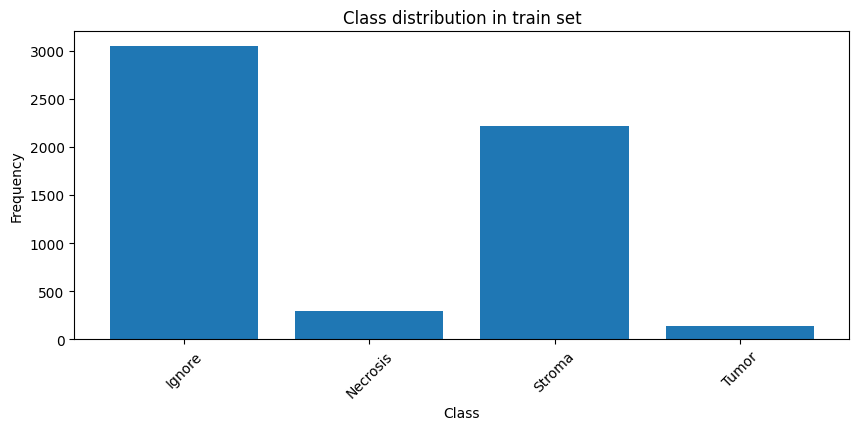

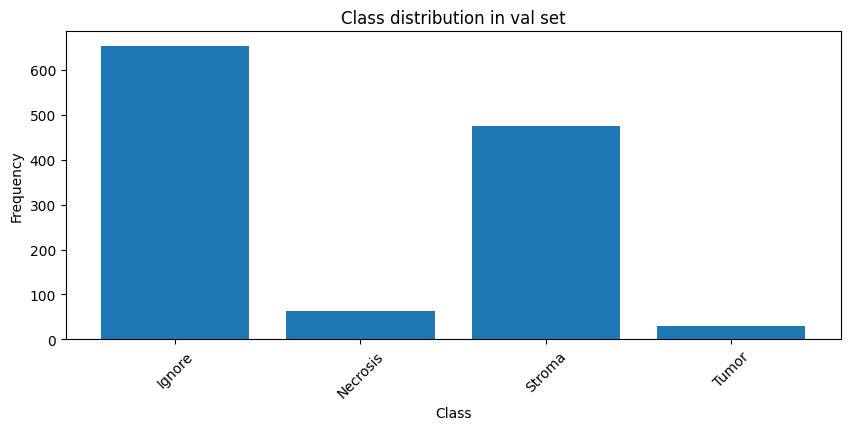

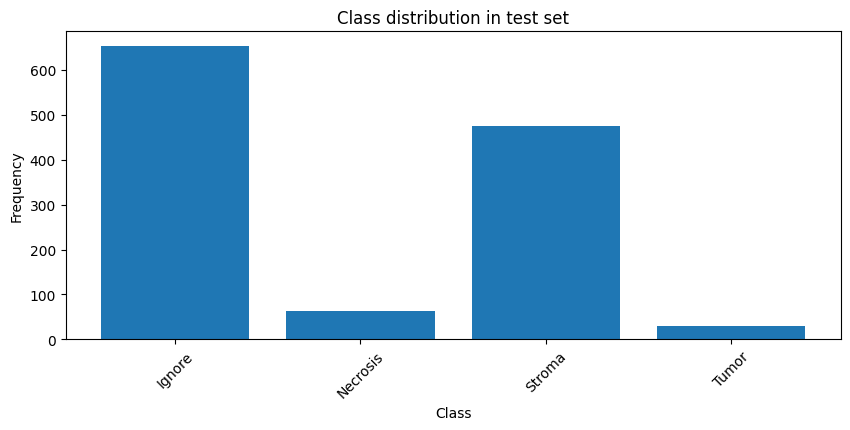

In [7]:
import matplotlib.pyplot as plt

# Check balance of classes in splits (fast: no image loading)
labels = list(data_meta["idx_to_class"].values())
targets = data_meta["targets"]
split_indices = data_meta["split_indices"]

for split in ["train", "val", "test"]:
    idxs = split_indices[split]
    split_targets = [targets[i] for i in idxs]
    counts = Counter(split_targets)
    freqs = [counts.get(i, 0) for i in range(len(labels))]
    plt.figure(figsize=(10, 4))
    plt.bar(labels, freqs)
    plt.title(f"Class distribution in {split} set")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

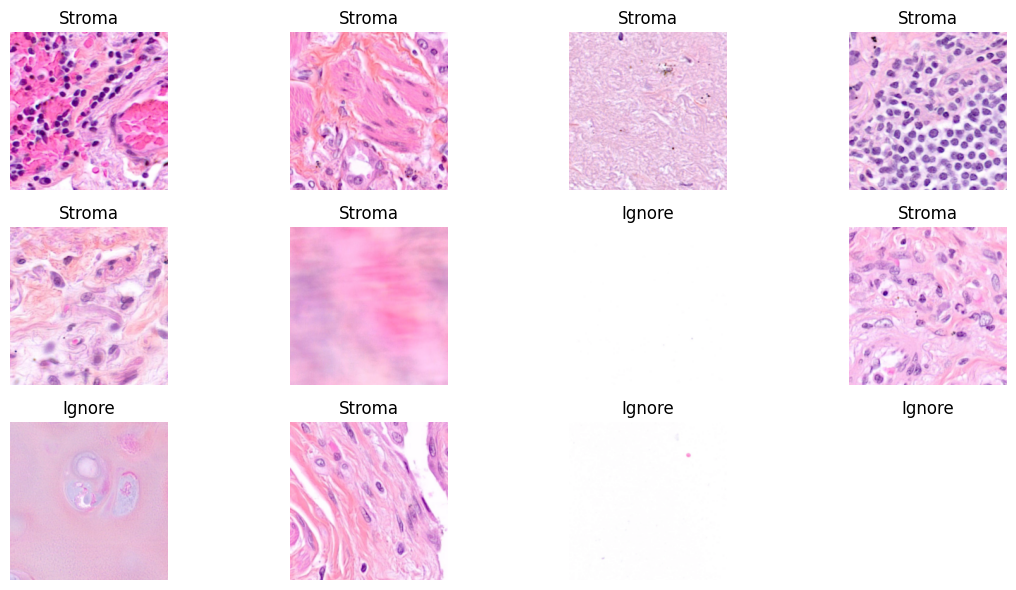

In [8]:
# Affichage robuste de quelques exemples du dataset (train) avec correction des couleurs
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader
import torch

to_pil = ToPILImage()
# On crée un DataLoader temporaire avec num_workers=0 pour éviter les problèmes de multiprocessing
train_subset = dataloaders['train'].dataset
loader_visu = DataLoader(train_subset, batch_size=4, shuffle=True, num_workers=0)
class_names = list(data_meta["idx_to_class"].values())

# Valeurs de normalisation utilisées dans les transforms
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(img):
    return img * std + mean

n_show = 12
plt.figure(figsize=(12, 6))
i = 0
for xb, yb in loader_visu:
    for k in range(xb.size(0)):
        if i >= n_show:
            break
        img = xb[k]
        label = class_names[yb[k].item()]
        img_visu = denormalize(img.cpu()).clamp(0, 1)
        plt.subplot(3, 4, i+1)
        plt.imshow(to_pil(img_visu))
        plt.title(label)
        plt.axis("off")
        i += 1
    if i >= n_show:
        break
plt.tight_layout()
plt.show()

In [9]:
import tqdm
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from model import CNN
    
model = CNN(num_classes=len(data_meta["class_to_idx"]))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_weight = None
if CFG.get("weighted_loss", False):
    loss_weight = data_meta["class_weights"].to(device)
criterion = nn.CrossEntropyLoss(weight=loss_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Metrics
history = [] 
epoch_train_loss = []
epoch_train_acc = []
epoch_val_loss = []
history_val = []
best_val_acc = 0.0
for epoch in tqdm.tqdm(range(30)):
    model.train()
    running_loss = 0.0
    running_samples = 0
    running_correct = 0
    for x, y in dataloaders["train"]:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        history.append(loss.item())
        running_loss += loss.item() * y.size(0)
        running_samples += y.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == y).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # epoch stats on training set
    train_loss_epoch = running_loss / running_samples if running_samples > 0 else 0.0
    train_acc_epoch = running_correct / running_samples if running_samples > 0 else 0.0
    epoch_train_loss.append(train_loss_epoch)
    epoch_train_acc.append(train_acc_epoch)

    # Validation: compute loss and accuracy
    model.eval()
    val_loss_accum = 0.0
    val_samples = 0
    val_correct = 0
    with torch.no_grad():
        for x, y in dataloaders['val']:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_loss_accum += loss.item() * y.size(0)
            val_samples += y.size(0)
            _, preds = torch.max(logits, 1)
            val_correct += (preds == y).sum().item()
        
    val_loss_epoch = val_loss_accum / val_samples if val_samples > 0 else 0.0
    val_acc_epoch = val_correct / val_samples if val_samples > 0 else 0.0
    if val_acc_epoch > best_val_acc:
        best_val_acc = val_acc_epoch
        torch.save(model.state_dict(), "best_model.pth")
    epoch_val_loss.append(val_loss_epoch)
    history_val.append(val_acc_epoch)

    print(f"Epoch {epoch+1}: train_loss={train_loss_epoch:.4f}, train_acc={train_acc_epoch:.4f}, val_loss={val_loss_epoch:.4f}, val_acc={val_acc_epoch:.4f}")

# After training: compute test metrics and confusion matrix
model.eval()
y_true = []
y_pred = []
y_prob = []
with torch.no_grad():
    for x, y in dataloaders['test']:
        x = x.to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(y.numpy().tolist())
        y_prob.extend(probs.cpu().numpy().tolist())

labels = [data_meta['idx_to_class'][i] for i in range(len(data_meta['idx_to_class']))]
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
prec, rec, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=list(range(len(labels))), zero_division=0)

print('\nClassification report:')
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))


/home/dimitri/histopathologic-classifier/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dimitri/histopathologic-classifier/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  3%|▎         | 1/30 [05:26<2:37:56, 326.78s/it]

Epoch 1: train_loss=0.3144, train_acc=0.7865, val_loss=0.3566, val_acc=0.7987


  7%|▋         | 2/30 [10:54<2:32:37, 327.06s/it]

Epoch 2: train_loss=0.0702, train_acc=0.9038, val_loss=0.2461, val_acc=0.8560


 10%|█         | 3/30 [16:25<2:28:02, 328.98s/it]

Epoch 3: train_loss=0.0488, train_acc=0.9320, val_loss=0.1766, val_acc=0.9059


 13%|█▎        | 4/30 [21:57<2:23:03, 330.14s/it]

Epoch 4: train_loss=0.0334, train_acc=0.9525, val_loss=0.1291, val_acc=0.9280


 17%|█▋        | 5/30 [27:28<2:17:44, 330.58s/it]

Epoch 5: train_loss=0.0269, train_acc=0.9627, val_loss=0.1378, val_acc=0.9264


 20%|██        | 6/30 [33:00<2:12:25, 331.08s/it]

Epoch 6: train_loss=0.0224, train_acc=0.9676, val_loss=0.0943, val_acc=0.9493


 23%|██▎       | 7/30 [38:35<2:07:22, 332.27s/it]

Epoch 7: train_loss=0.0172, train_acc=0.9756, val_loss=0.0813, val_acc=0.9574


 27%|██▋       | 8/30 [44:08<2:01:56, 332.55s/it]

Epoch 8: train_loss=0.0173, train_acc=0.9755, val_loss=0.0674, val_acc=0.9714


 30%|███       | 9/30 [49:48<1:57:13, 334.91s/it]

Epoch 9: train_loss=0.0142, train_acc=0.9772, val_loss=0.0605, val_acc=0.9714


 33%|███▎      | 10/30 [55:24<1:51:46, 335.32s/it]

Epoch 10: train_loss=0.0135, train_acc=0.9777, val_loss=0.0630, val_acc=0.9673


 37%|███▋      | 11/30 [1:00:59<1:46:08, 335.20s/it]

Epoch 11: train_loss=0.0116, train_acc=0.9825, val_loss=0.0566, val_acc=0.9746


 40%|████      | 12/30 [1:06:30<1:40:11, 333.96s/it]

Epoch 12: train_loss=0.0113, train_acc=0.9825, val_loss=0.0475, val_acc=0.9763


 43%|████▎     | 13/30 [1:12:06<1:34:45, 334.47s/it]

Epoch 13: train_loss=0.0098, train_acc=0.9860, val_loss=0.0514, val_acc=0.9771


 47%|████▋     | 14/30 [1:17:44<1:29:28, 335.51s/it]

Epoch 14: train_loss=0.0105, train_acc=0.9870, val_loss=0.0499, val_acc=0.9771


 50%|█████     | 15/30 [1:23:29<1:24:37, 338.47s/it]

Epoch 15: train_loss=0.0090, train_acc=0.9874, val_loss=0.0540, val_acc=0.9714


 53%|█████▎    | 16/30 [1:29:05<1:18:46, 337.63s/it]

Epoch 16: train_loss=0.0141, train_acc=0.9849, val_loss=0.0446, val_acc=0.9804


 57%|█████▋    | 17/30 [1:34:39<1:12:56, 336.62s/it]

Epoch 17: train_loss=0.0098, train_acc=0.9846, val_loss=0.0468, val_acc=0.9771


 60%|██████    | 18/30 [1:40:17<1:07:23, 336.93s/it]

Epoch 18: train_loss=0.0071, train_acc=0.9888, val_loss=0.0422, val_acc=0.9795


 63%|██████▎   | 19/30 [1:45:57<1:01:55, 337.81s/it]

Epoch 19: train_loss=0.0082, train_acc=0.9867, val_loss=0.0381, val_acc=0.9853


 67%|██████▋   | 20/30 [1:51:35<56:20, 338.05s/it]  

Epoch 20: train_loss=0.0107, train_acc=0.9881, val_loss=0.0373, val_acc=0.9820


 70%|███████   | 21/30 [1:57:11<50:34, 337.21s/it]

Epoch 21: train_loss=0.0066, train_acc=0.9907, val_loss=0.0388, val_acc=0.9812


 73%|███████▎  | 22/30 [2:02:53<45:10, 338.80s/it]

Epoch 22: train_loss=0.0096, train_acc=0.9907, val_loss=0.0393, val_acc=0.9787


 77%|███████▋  | 23/30 [2:08:25<39:17, 336.81s/it]

Epoch 23: train_loss=0.0080, train_acc=0.9888, val_loss=0.0365, val_acc=0.9820


 80%|████████  | 24/30 [2:14:04<33:43, 337.33s/it]

Epoch 24: train_loss=0.0061, train_acc=0.9914, val_loss=0.0353, val_acc=0.9812


 83%|████████▎ | 25/30 [2:19:33<27:54, 334.96s/it]

Epoch 25: train_loss=0.0047, train_acc=0.9932, val_loss=0.0361, val_acc=0.9812


 87%|████████▋ | 26/30 [2:25:15<22:28, 337.14s/it]

Epoch 26: train_loss=0.0045, train_acc=0.9932, val_loss=0.0323, val_acc=0.9828


 90%|█████████ | 27/30 [2:30:44<16:43, 334.54s/it]

Epoch 27: train_loss=0.0044, train_acc=0.9916, val_loss=0.0324, val_acc=0.9804


 93%|█████████▎| 28/30 [2:36:19<11:09, 334.83s/it]

Epoch 28: train_loss=0.0040, train_acc=0.9935, val_loss=0.0350, val_acc=0.9836


 97%|█████████▋| 29/30 [2:41:57<05:35, 335.60s/it]

Epoch 29: train_loss=0.0037, train_acc=0.9947, val_loss=0.0277, val_acc=0.9836


100%|██████████| 30/30 [2:47:36<00:00, 335.21s/it]

Epoch 30: train_loss=0.0046, train_acc=0.9926, val_loss=0.0274, val_acc=0.9869



Classification report:
              precision    recall  f1-score   support

      Ignore       0.99      0.99      0.99       653
    Necrosis       0.98      1.00      0.99        64
      Stroma       0.98      0.98      0.98       475
       Tumor       0.97      1.00      0.98        30

    accuracy                           0.99      1222
   macro avg       0.98      0.99      0.99      1222
weighted avg       0.99      0.99      0.99      1222



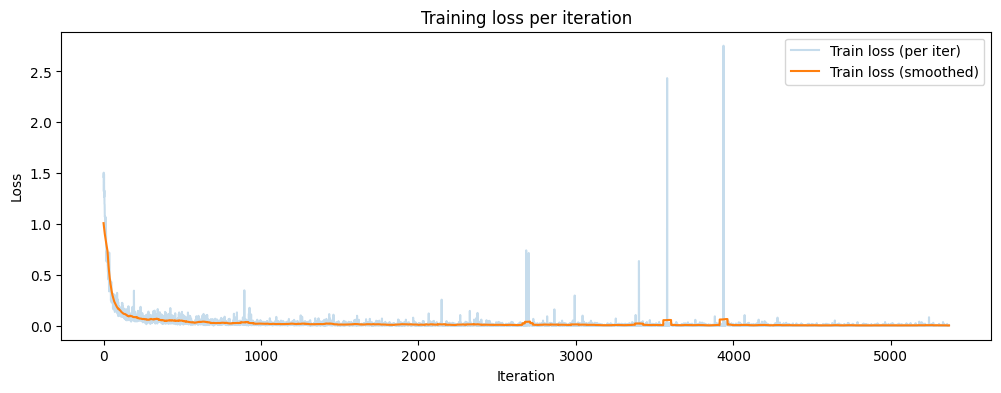

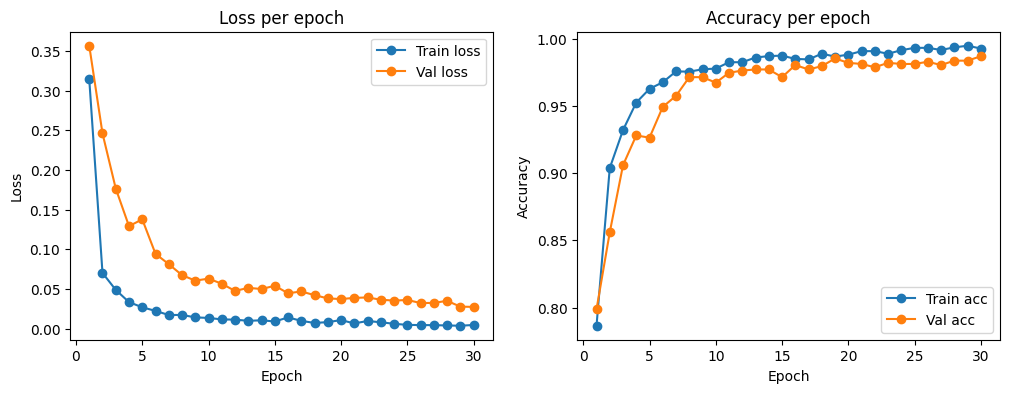

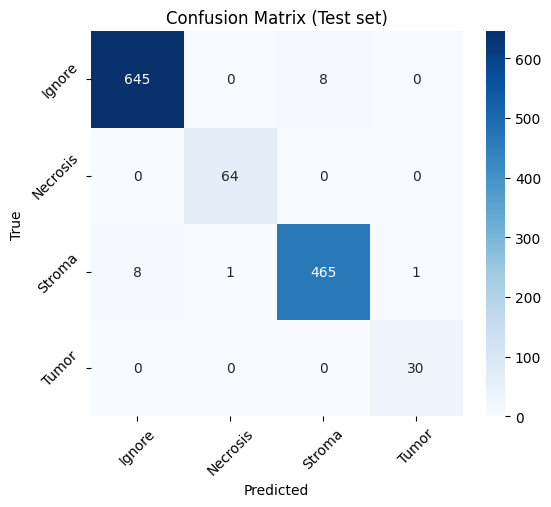

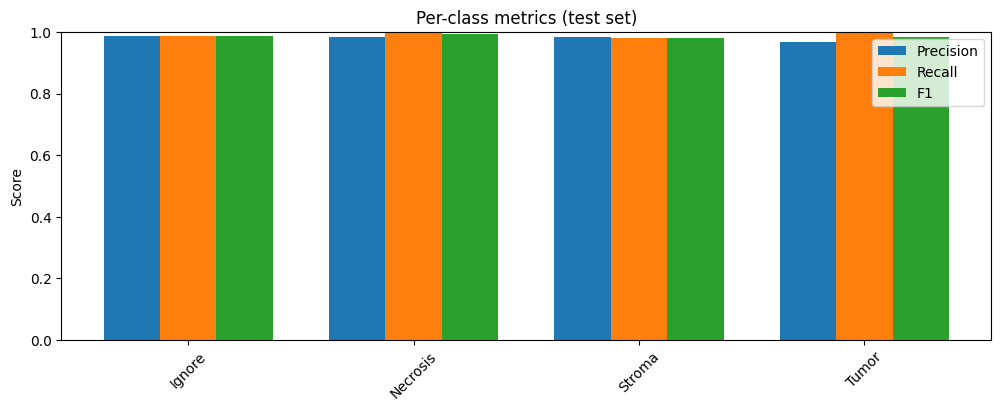

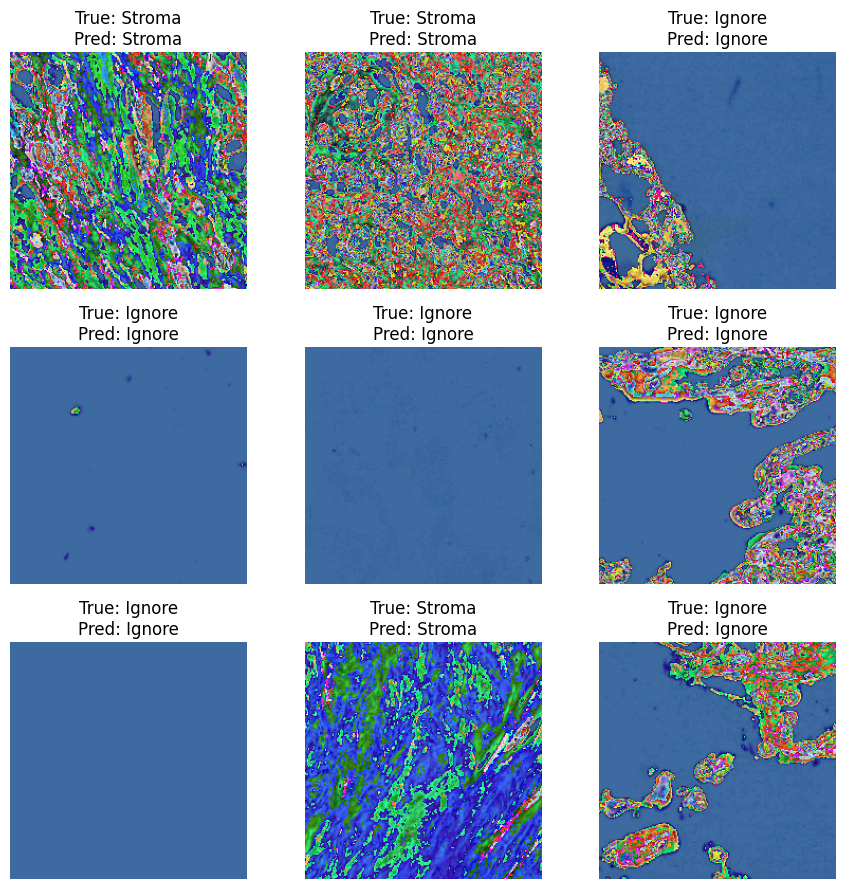

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

def smooth(x, window=50):
    if len(x) < window:
        return np.array(x)
    return pd.Series(x).rolling(window, min_periods=1, center=True).mean().to_numpy()

# Per-iteration training loss (smoothed)
plt.figure(figsize=(12, 4))
plt.plot(history, alpha=0.25, label='Train loss (per iter)')
plt.plot(smooth(history, window=50), label='Train loss (smoothed)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss per iteration')
plt.legend()
plt.show()

# Epoch-level losses and accuracies
epochs = list(range(1, len(epoch_train_loss) + 1))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_train_loss, '-o', label='Train loss')
plt.plot(epochs, epoch_val_loss, '-o', label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_train_acc, '-o', label='Train acc')
plt.plot(epochs, history_val, '-o', label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch')
plt.legend()
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test set)')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Per-class precision, recall, f1
x = np.arange(len(labels))
width = 0.25
plt.figure(figsize=(12, 4))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1')
plt.xticks(x, labels, rotation=45)
plt.title('Per-class metrics (test set)')
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.legend()
plt.show()

# Show some test images with predicted vs true labels
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()
n_show = 9
plt.figure(figsize=(9, 9))
i = 0
for (x, y) in dataloaders['test'] :
    for k in range(x.size(0)) :
        if i >= n_show :
            break
        img = x[k]
        true = labels[y[k].item()]
        pred = labels[y_pred[i]]
        plt.subplot(3, 3, i+1)
        plt.imshow(to_pil(img.cpu()))
        plt.title(f'True: {true}\nPred: {pred}')
        plt.axis('off')
        i += 1
    if i >= n_show :
        break
plt.tight_layout()
plt.show()